## Food segmentation and volume estimation

In [1]:
# Import necessary libraries
import torch
import torchvision
import os
import cv2
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList, ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [2]:
# Path for segmentation dataset
datapath = os.path.join("FoodSeg103","FoodSeg103","Images")

# images and annotation dataset
image_data = os.path.join(datapath,"img_dir","train")
ann_data = os.path.join(datapath,"ann_dir","train")

valid_split = 0.2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# pin memory
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CHANNELS = 3
NUM_CLASSES = 103
NUM_LEVELS = 3

LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64

INPUT_IMG_WIDTH = 256
INPUT_IMG_HEIGHT = 256

THRESHOLD = 0.5

OUTPUT_PATH = "output"
MODEL_PATH = os.path.join(OUTPUT_PATH,"model.pth")
PLOT = os.path.sep.join([OUTPUT_PATH,"plot.png"])
TEST_PATH = os.path.sep.join([OUTPUT_PATH,"test_path.txt"])


In [3]:
# Object detection dataset

category_data_path = os.path.join("UECFOOD100","category.txt")
categories = {}
with open(category_data_path,"r") as f:
    for line in f:
        idx, category = line.strip().split()
        categories[idx] = category
categories.pop("id")

'name'

In [4]:
# Visualize the image and bounding box
data_path = os.path.join(os.getcwd(),"UECFOOD100")
all_label = {}
for i in os.listdir(data_path):
    label_path = os.path.join(data_path,i)
    if i.isdigit():
        for j in os.listdir(label_path):
            bbox = {}
            if j.endswith(".txt"):
                bbox_path = os.path.join(label_path,j)
                with open(bbox_path,"r") as f:
                    for line in f:
                        filename, x0, y0, x2,y2 = line.strip().split()
                        bbox[str(filename)] = [x0,y0,x2,y2]
                    all_label[i] = bbox

In [9]:
# visualize bbox
def visualize_bbox(data_path,label):
#     for i in os.listdir(data_path):
    label_path = os.path.join(data_path,label)
    all_images = glob.glob(os.path.join(label_path,"*.jpg"))
    img_path = random.choice(all_images)
    print(os.path.split(img_path)[1])
#     for j in os.listdir(label_path):
#     img_path = os.path.join(label_path,j)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    bbox = all_label.get(label).get(os.path.split(img_path)[1].split('.')[0])
    cv2.rectangle(img,(int(bbox[0]),int(bbox[1])),(int(bbox[2]),int(bbox[3])),(0,0,255),2)
    cv2.putText(img,categories.get(label),(int(bbox[0])+10,int(bbox[1])-5),cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,255), 1)
    plt.imshow(img)
    plt.show()

16782.jpg


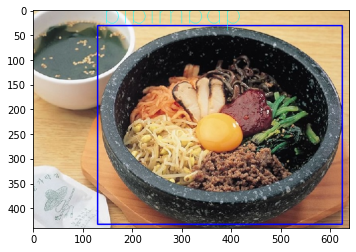

In [18]:
root_path = os.path.join(os.getcwd(),"UECFOOD100")
visualize_bbox(root_path,"11")


In [16]:
# Dataset class

class FoodDataset(Dataset):
    def __init__(self,imagepath,maskpath,transforms):
        self.imagepath = imagepath
        self.maskpath = maskpath
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imagepath)
    
    def __getitem__(self,idx):
        imagePath = self.imagepath[idx]
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.maskpath[idx],0)
        
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            
        return (image,mask)
    

In [ ]:
# Dataset class

class FoodDataset(Dataset):
    def __init__(self,imagepath,maskpath,transforms):
        self.imagepath = imagepath
        self.maskpath = maskpath
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imagepath)
    
    def __getitem__(self,idx):
        imagePath = self.imagepath[idx]
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.maskpath[idx],0)
        
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            
        return (image,mask)
    

In [11]:
# model (U-net)
class Model(Module):
    def __init__(self,inChannels, outChannels):
        super.__init__()
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = Relu()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    
    def forward(self,x):
        return self.conv2(self.relu(self.conv1(x)))
    
class Encoder(Module):
    def __init__(self,channels=(3,16,32,64)):
        super.__init__()
        self.encBlocks = ModuleList([Model(channels[i],channels[i+1]) for i in range(len(channels)-1)])
        self.pool = MaxPool2d(2)
        
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []

        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)

        # return the list containing the intermediate outputs
        return blockOutputs
    
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])

    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)

            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)

        # return the final decoder output
        return x

    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures
        
        


In [15]:
class UNet(Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
         decChannels=(64, 32, 16),
         nbClasses=1, retainDim=True,
         outSize=(INPUT_IMG_HEIGHT,  INPUT_IMG_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)

        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
            encFeatures[::-1][1:])

        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)

        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)

        # return the segmentation map
        return map

In [18]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
    test_size=config.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()


NameError: name 'config' is not defined

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\admin\Desktop\dev\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "C:\Users\admin\Desktop\dev\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\admin\appdata\local\programs\python\python37\lib\logging\__init__.py", line 1029, in emit
    self.flush()
  File "c:\users\admin\appdata\local\programs\python\python37\lib\logging\__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "c:\users\admin\appdata\local\programs\python\python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\admin\appdata\local\programs\python\python37\lib\ru

In [ ]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
     transforms.Resize((config.INPUT_IMAGE_HEIGHT,
        config.INPUT_IMAGE_WIDTH)),
    transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
    transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
    batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
    num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
    batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
    num_workers=os.cpu_count())

In [ ]:
# initialize our UNet model
unet = UNet().to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)

		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()

		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)

# serialize the model to disk
torch.save(unet, config.MODEL_PATH)

In [ ]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)

	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")

	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [ ]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()

	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0

		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()

		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
			filename)

		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
			config.INPUT_IMAGE_HEIGHT))

In [ ]:
# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(config.DEVICE)

		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()

		# filter out the weak predictions and convert them to integers
		predMask = (predMask > config.THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)

		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)

# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path) 